<h1 align="center"><b>Financial Sentiment Analysis with Artificial Neural Network
</b></h1>

## **Introduction**


- **Nama : Brian Nabiel Raharja**

- **Batch : HCK-030**

- **email : nabielbrian@gmail.com**

### **Dataset Breakdown**

- link Deploy : https://huggingface.co/spaces/briannabielraharja/predict_sentiment
- link Kaggle : https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis/data 
- Overview: Dataset berisi ribuan teks finansial dengan label sentimen (positif, netral, negatif). Data ini merepresentasikan opini publik terkait isu keuangan.

Kolom:
- text → isi komentar/berita/kalimat finansial.
- sentiment → label target: positive, neutral, negative

### **Objective Breakdown**

- Tujuan penelitian: Membangun model deep learning (ANN) untuk klasifikasi sentimen finansial.
- Tujuan bisnis:
    - Positive Sentiment → mengidentifikasi optimisme publik terhadap pasar/produk (indikasi peluang investasi).
    - Neutral Sentiment → menangkap opini pasif untuk memantau kestabilan persepsi.
    - Negative Sentiment → mendeteksi potensi risiko, krisis, atau isu yang bisa memengaruhi keputusan bisnis.

### **Background**



Dalam dunia keuangan, sentimen pasar sangat memengaruhi arah keputusan investasi. Berita dan opini publik mampu menggerakkan harga saham secara signifikan. Sayangnya, data sentimen dalam bentuk teks tidak langsung bisa dipahami secara kuantitatif.
Proyek ini dibuat untuk mengubah data teks finansial menjadi insight melalui Artificial Neural Network (ANN), sehingga opini publik dapat diukur dan digunakan dalam mendukung pengambilan keputusan.

### **Business Understanding**



- Domain: Analisis sentimen di bidang keuangan (finance).
- Masalah bisnis: Bagaimana cara mengidentifikasi sentimen publik (positif, negatif, netral) secara otomatis dari data teks finansial?
- Pentingnya solusi:
  - Investor bisa lebih cepat membaca arah pasar.
  - Perusahaan bisa memahami persepsi publik terhadap produk/layanan finansialnya.
  - Peneliti bisa memanfaatkan dataset ini untuk riset lebih lanjut.

### **Methodology**

1. Data Loading & Cleaning
2. Exploratory Data Analysis (EDA)
3. Preprocessing teks (tokenisasi, stopwords, embedding)
4. Training ANN baseline
5. ANN improvement
6. Model evaluation & comparison
7. Model saving
8. Deployment (misalnya Hugging Face/Streamlit)

### **Evaluation Metrics**

### **Expected Impact**


Investor & analis keuangan: memahami arah sentimen pasar lebih cepat.

## **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Embedding
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import files
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
import json

## **Data Loading**

In [52]:
uploaded = files.upload()
df = pd.read_csv(list(uploaded.keys())[0])

Saving data.csv to data (1).csv


kodingan ini fungsinya mengambil dataset dari lokal, memasukkannya ke environment Colab, lalu membaca ke dalam pandas DataFrame agar bisa dipakai di tahap selanjutnya.

## **Data Understanding**

In [53]:
# lihat ukuran dataset
print("Shape:", df.shape)

Shape: (5842, 2)


→ Mengecek ukuran dataset.
- Hasil: (5842, 2) → berarti ada 5.842 baris dan 2 kolom.
- Kesimpulan: dataset cukup besar (ribuan baris), dengan struktur sederhana: teks + label.

In [54]:
# cek 5 baris pertama
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


→ Menampilkan 5 baris pertama.
- Hasil: terlihat kolom Sentence (teks berita/komentar) dan Sentiment (label: positive, negative, neutral).

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


- Tidak ada missing value → dataset bersih, tidak perlu tahap cleaning untuk missing data.
- Kolom teks (Sentence) & label (Sentiment) sudah sesuai kebutuhan untuk NLP task.

## **Exploratory Data Analysis**

### **1. Bagaimana distribusi jumlah data pada ketiga label sentimen (positive, negative, neutral), dan apakah terdapat ketidakseimbangan kelas (class imbalance) yang perlu diperhatikan?**

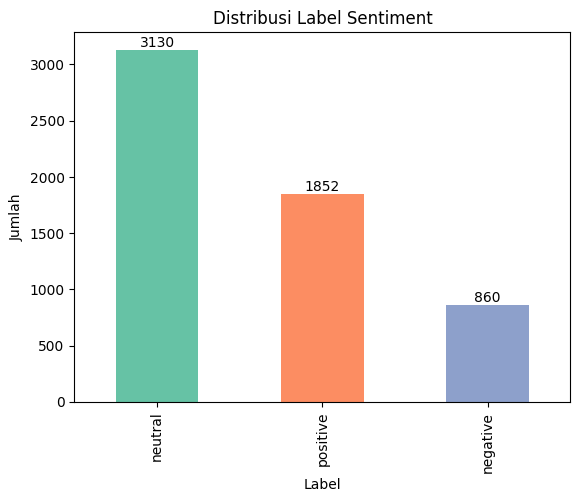

In [56]:
df_vis = df.copy()

counts = df_vis["Sentiment"].value_counts()
ax = counts.plot(kind="bar", color=["#66c2a5","#fc8d62","#8da0cb"])
ax.set_title("Distribusi Label Sentiment")
ax.set_xlabel("Label")
ax.set_ylabel("Jumlah")

for i, v in enumerate(counts.values):
    ax.text(i, v, str(v), ha="center", va="bottom")
plt.show()

1. **3,130 data (53,6%) berlabel neutral**
  - Mayoritas teks bersifat netral.
  - Artinya banyak teks finansial bersifat informatif (laporan harga, kondisi pasar, berita), bukan opini emosional.
2. **1,852 data (31,7%) berlabel positive**
  - Sekitar sepertiga dataset.
  - Menunjukkan cukup banyak berita/teks bernuansa optimis (pertumbuhan, keuntungan, prospek pasar).
3. **860 data (14,7%) berlabel negative**
  - Jumlah paling kecil.
  - Artinya sentimen negatif relatif jarang muncul, ini bisa menimbulkan masalah imbalance saat melatih model.

### **2. Bagaimana distribusi jumlah kata per kalimat pada seluruh dataset, dan rentang panjang teks seperti apa yang paling sering muncul?**

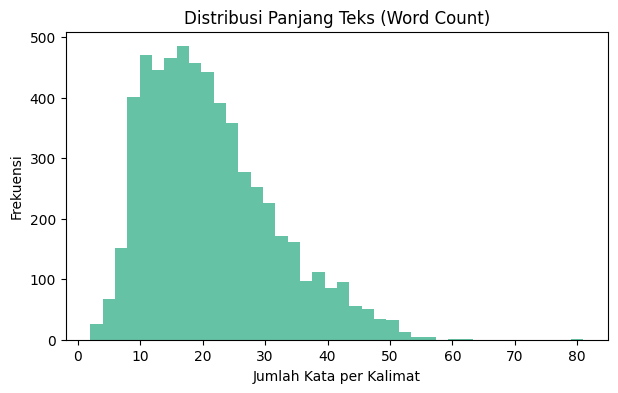

In [57]:
df_vis["word_count"] = df_vis["Sentence"].astype(str).str.split().str.len()

plt.figure(figsize=(7,4))
plt.hist(df_vis["word_count"], bins=40, color="#66c2a5")
plt.title("Distribusi Panjang Teks (Word Count)")
plt.xlabel("Jumlah Kata per Kalimat")
plt.ylabel("Frekuensi")
plt.show()

**1. Rentang jumlah kata: teks berkisar antara 1 hingga ±80 kata per kalimat.**
- Menunjukkan ada variasi cukup luas, dari kalimat sangat singkat sampai cukup panjang.

**2. Mayoritas teks berada pada kisaran 10–25 kata**
- Distribusi membentuk peak sekitar 15–20 kata. Ini berarti sebagian besar kalimat cukup singkat, tipikal untuk berita/headline finansial.

**3. Sebagian kecil teks panjang (40–80 kata)**
- Relatif jarang muncul, sehingga bisa dianggap outlier alami tapi tetap berguna karena mungkin berisi detail lebih kaya.

### **3. Apakah terdapat perbedaan panjang teks yang signifikan di antara label positive, negative, dan neutral?**

<Figure size 600x400 with 0 Axes>

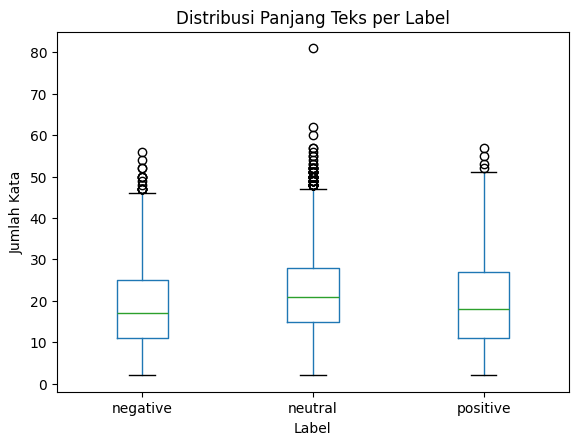

In [58]:
plt.figure(figsize=(6,4))
df_vis.boxplot(column="word_count", by="Sentiment", grid=False)
plt.title("Distribusi Panjang Teks per Label")
plt.suptitle("")
plt.xlabel("Label")
plt.ylabel("Jumlah Kata")
plt.show()

**1. Negative**
- Median panjang teks sekitar 15 kata.
- Rentang interkuartil (IQR) antara ±10–25 kata.
- Ada outlier hingga >45 kata, tapi jumlahnya relatif sedikit.
→ Kalimat bernuansa negatif cenderung singkat, langsung ke inti masalah.

**2. Neutral**
- Median lebih tinggi, sekitar 20 kata.
- IQR lebih lebar (±13–28 kata).
- Banyak outlier panjang, bahkan sampai 80 kata.
→ Kalimat netral sering berupa laporan detail atau informasi faktual yang lebih panjang.

**3. Positive**
- Median panjang sekitar 16–17 kata.
- IQR ±12–25 kata.
- Outlier mencapai >50 kata, tapi tidak sebanyak kelas neutral.
→ Kalimat positif cenderung singkat hingga sedang, tidak sepanjang teks netral.

### **4. Apa saja token (kata) yang paling sering muncul pada masing-masing label (positive, negative, neutral), dan bagaimana perbedaan karakteristik antar label berdasarkan token dominan tersebut?**

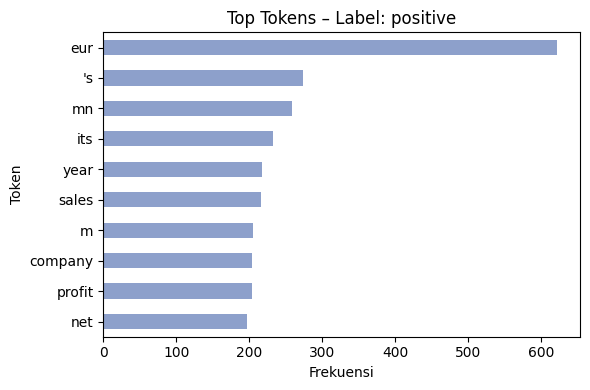

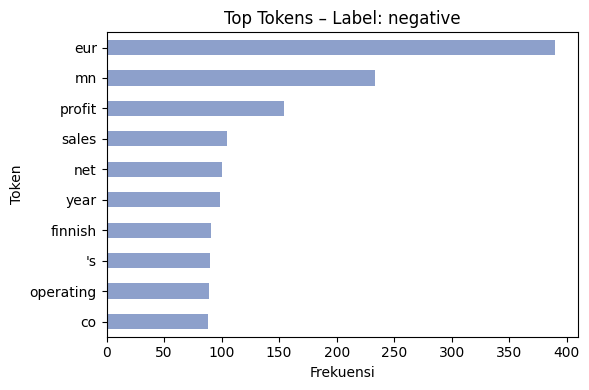

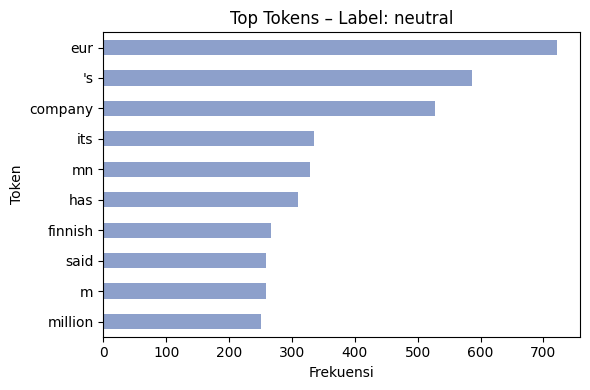

In [59]:
STOPWORDS = {
    "the","and","to","of","in","on","for","a","an","is","are","was","were","be","been","being",
    "this","that","it","as","at","by","from","with","or","but","not","no","so","if","then","than",
    "into","over","under","up","down","out","very","can","could","should","would","will","may","might"
}

def tokenize(text):
    # ambil kata alphabetic (angka & simbol diabaikan biar fokus kata)
    return [t.lower() for t in re.findall(r"[A-Za-z']+", str(text)) if t]

def top_tokens(series_text, n=10):
    c = Counter()
    for t in series_text:
        toks = [w for w in tokenize(t) if w not in STOPWORDS]
        c.update(toks)
    return pd.Series(dict(c.most_common(n)))

# ambil semua label unik
labels = df_vis["Sentiment"].unique().tolist()

# loop tiap label → plot top tokens
for lab in labels:
    subset = df_vis.loc[df_vis["Sentiment"] == lab, "Sentence"]
    tt = top_tokens(subset, n=10)

    plt.figure(figsize=(6,4))
    tt.sort_values().plot(kind="barh", color="#8da0cb")
    plt.title(f"Top Tokens – Label: {lab}")
    plt.xlabel("Frekuensi")
    plt.ylabel("Token")
    plt.tight_layout()
    plt.show()

**1. Positive**
- eur (±620 kali) → dominan, karena banyak berita keuangan menyebut mata uang Euro; tidak spesifik positif, tapi sering muncul pada konteks laba.
- profit, sales, net → kata finansial khas yang bernuansa pertumbuhan dan keuntungan → selaras dengan label positif.
- company, year, mn (million) → kata informatif umum terkait laporan keuangan.
- Insight: kelas positif banyak mengandung kata yang menekankan kinerja baik (profit, sales) selain informasi kuantitatif (EUR, MN).

2. **Negative**
- eur (±390 kali) → lagi-lagi dominan, konteksnya netral tapi digunakan dalam kalimat bernuansa rugi.
- profit, sales, net → muncul juga, tapi konteksnya sering negatif (profit turun, sales melemah, net loss).
- operating, finnish → mengindikasikan berita perusahaan spesifik (misal Finland-based company) dengan kondisi keuangan buruk.
- Insight: kelas negatif tidak ditandai kata berbeda, melainkan oleh frasa konteks (penurunan, rugi, biaya operasional). Model perlu mampu menangkap nuansa ini.

3. **Neutral**
- eur (±740 kali) → paling sering di kelas netral, wajar karena banyak headline hanya menyampaikan angka/nilai tukar tanpa sentimen.
- company, its, said, has → tipikal bahasa laporan berita → menggambarkan teks yang bersifat faktual dan netral.
- million, mn → angka besar disebut sebagai informasi, bukan penilaian.
- Insight: kelas netral dicirikan oleh bahasa pelaporan (said, has, company) → cenderung deskriptif tanpa kata emosional.

### **5. Bigram (pasangan kata) apa yang paling sering muncul pada masing-masing label (positive, negative, neutral), dan apakah bigram ini memberikan konteks yang khas untuk tiap label sentimen?**

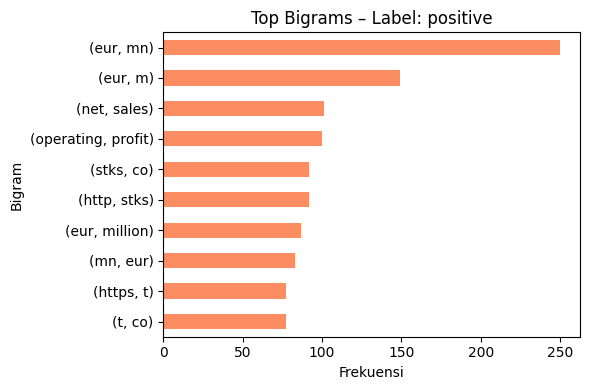

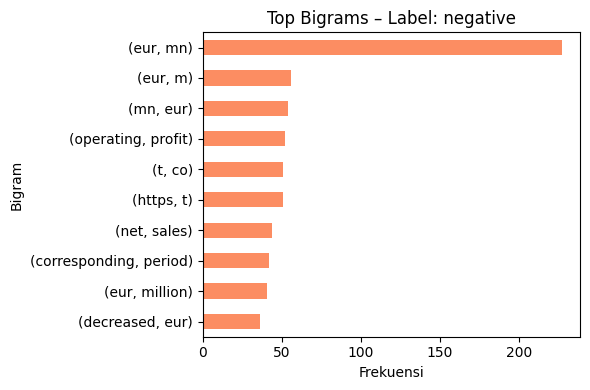

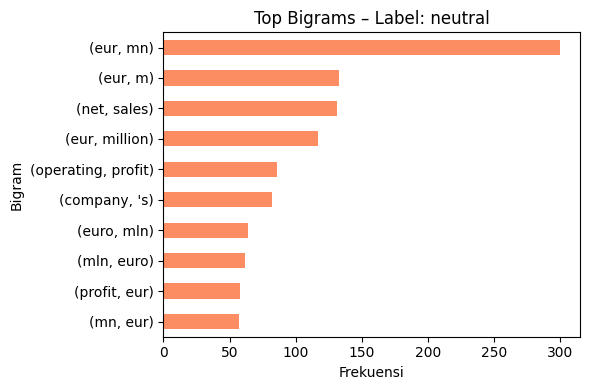

In [60]:
def tokenize_words(text):
    return [t.lower() for t in re.findall(r"[A-Za-z']+", str(text)) if t]

def get_bigrams(tokens):
    return [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)]

def top_bigrams(series_text, n=10):
    c = Counter()
    for t in series_text:
        toks = [w for w in tokenize_words(t) if w not in STOPWORDS]
        bigs = get_bigrams(toks)
        c.update(bigs)
    return pd.Series(dict(c.most_common(n)))

# plot bigram per label
labels = df_vis["Sentiment"].unique().tolist()
for lab in labels:
    subset = df_vis.loc[df_vis["Sentiment"] == lab, "Sentence"]
    tb = top_bigrams(subset, n=10)

    plt.figure(figsize=(6,4))
    tb.sort_values().plot(kind="barh", color="#fc8d62")
    plt.title(f"Top Bigrams – Label: {lab}")
    plt.xlabel("Frekuensi")
    plt.ylabel("Bigram")
    plt.tight_layout()
    plt.show()

1. **Positive**
- (eur, mn) dan (eur, m) → bigram dominan, wajar karena banyak laporan keuangan menggunakan format nilai (EUR mn = Euro million).
- (net, sales), (operating, profit) → mengindikasikan laporan keuangan bernuansa pertumbuhan/hasil kinerja → cocok dengan label positif.
- Insight: kelas positif banyak mengandung frasa finansial kuantitatif (profit, sales) yang berasosiasi dengan hasil baik.
2. **Negative**
- (eur, mn) dan (eur, m) juga muncul kuat → menunjukkan konteks mata uang dominan di semua label.
- (operating, profit), (net, sales) → mirip positif, tapi konteks kalimatnya kemungkinan menggambarkan penurunan (loss, turun).
- (decreased, eur) → bigram khas negatif, menguatkan bahwa kata penurunan - (decreased) memang mengarahkan ke label negatif.
- Insight: kelas negatif dibedakan bukan hanya oleh kata umum “profit/sales”, tetapi oleh kombinasi dengan kata penanda penurunan seperti decreased.
3. **Neutral**
- (eur, mn) kembali dominan (lebih dari 300 kali) → karena neutral banyak berupa laporan angka murni.
- (company, 's), (said, …) → tipikal bahasa laporan berita faktual.
- (profit, eur), (operating, profit) → muncul, tetapi dalam bentuk deskriptif (misalnya: “operating profit was EUR X million”), bukan evaluatif.
- Insight: kelas neutral sangat dicirikan oleh frasa pelaporan angka/statemen (company’s, said, has, mn), berbeda dari kelas positif/negatif yang membawa nuansa evaluasi.

## **Feature Engineering**

### **Text Preprocessing**

In [61]:
# tentukan kolom text & label
TEXT_COL  = "Sentence"
LABEL_COL = "Sentiment"

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df[[TEXT_COL, LABEL_COL]].head()

Shape: (5842, 2)
Columns: ['Sentence', 'Sentiment']


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


- Menentukan kolom teks & label → Sentence sebagai input teks, Sentiment sebagai target.
- Cek ukuran dataset → hasilnya (5842, 2) artinya ada 5842 baris, 2 kolom.
- Jadi cell ini intinya setup awal untuk memastikan data teks dan label sudah siap diproses ke tahap preprocessing berikutnya.

In [62]:
# base stopwords
base_stop = set(ENGLISH_STOP_WORDS)

# jaga negasi
neg_keep = {"no", "not", "nor", "never"}

# whitelist kata finansial penting
fin_keep = {
    "eur","usd","gbp","jpy","idr","cpi","gdp","eps","revenue","sales","profit","loss",
    "upgrade","downgrade","guidance","million","billion","percent","mn","bn",
    "dividend","buyback","merger","acquisition","ipo","outlook","margin","yoy","qoq",
    "beat","miss","debt","equity","cash","capex","tkr"
}

STOPWORDS = (base_stop - neg_keep) - fin_keep

**FLow Kode**
1. base_stop → ambil daftar stopwords standar bahasa Inggris (ENGLISH_STOP_WORDS).
2. neg_keep → buat set kata negasi penting (no, not, nor, never) supaya tidak dihapus.
3. fin_keep → whitelist kata-kata finansial penting (misal: eur, usd, profit, loss, revenue, sales, upgrade, downgrade, dividend, equity) supaya tetap dipertahankan.
4. stopwords standar dikurangi kata negasi + kata finansial penting.

**Objective**
1. Membersihkan teks dari kata-kata umum tidak bermakna,
2. Tetap menjaga kata penting dalam analisis sentimen finansial (profit, loss, revenue),
3. Tidak menghapus negasi karena sangat memengaruhi makna sentimen (“profit” ≠ “no profit”).

In [63]:
# regex pattern
re_url     = re.compile(r"http\S+|www\.\S+|\S+@\S+|#\S+")
re_ticker  = re.compile(r"\$([A-Za-z]{1,5})\b")
re_contrnt = re.compile(r"n['’]t\b")
re_apost   = re.compile(r"['’]")
re_bn      = re.compile(r"\b(\d+(?:\.\d+)?)\s?(bn|b|billion|bln)\b")
re_mn      = re.compile(r"\b(\d+(?:\.\d+)?)\s?(mn|m|mio|million)\b")
re_numcomm = re.compile(r"(?<=\d),(?=\d)")
re_nonword = re.compile(r"[^a-z0-9_%\s]")
re_tokens  = re.compile(r"[a-z0-9_]+")

def preprocess_fin(s: str) -> str:
    t = str(s).lower().strip()
    # negation contraction
    t = re_contrnt.sub(" not", t)
    t = re_apost.sub("", t)
    # hapus url/email/hashtag
    t = re_url.sub(" ", t)
    # ticker → tkr_xxx
    t = re_ticker.sub(lambda m: f"tkr_{m.group(1).lower()}", t)
    # normalisasi simbol & persen
    t = t.replace("€"," eur ").replace("$"," usd ").replace("£"," gbp ").replace("¥"," jpy ")
    t = t.replace("%"," percent ")
    # normalisasi angka + satuan
    t = re_numcomm.sub("", t)
    t = re_bn.sub(r"\1 billion", t)
    t = re_mn.sub(r"\1 million", t)
    # hapus non-word & rapikan spasi
    t = re_nonword.sub(" ", t)
    t = re.sub(r"\s+"," ", t).strip()
    # tokenisasi & filter stopwords
    toks = re_tokens.findall(t)
    toks = [w for w in toks if (w not in STOPWORDS and w != "s")]
    return " ".join(toks)

**Flow Kode**
1. ``Siapkan regex untuk``: URL/email/hashtag, ticker saham ($AAPL), kontraksi negasi (n't), apostrof, satuan besar (bn/mn), angka ber-koma, non-alphabetic, dan token ([a-z0-9_]+).
2. ``preprocess_fin(s)``:
    - Lowercase + strip.
    - Negation handling: ubah don't → do not lalu hapus apostrof lain.
    - Hapus URL/email/hashtag.
    - Normalisasi ticker: $AAPL → tkr_aapl.
    - Normalisasi simbol: €/$/£/¥ → eur/usd/gbp/jpy, % → percent.
    - Normalisasi angka: hilangkan koma ribuan; standarkan satuan bn/mn.
    - Bersihkan non-word & spasi ganda.
    - Tokenisasi + filter stopwords, tapi jaga negasi & whitelist kata finansial (sesuai set yang sudah kamu buat).
    - Gabung kembali token jadi string.

**Objective**
- Membersihkan & menormalkan teks finansial supaya lebih konsisten.
- Menjaga konteks domain:
  - Tidak kehilangan kata penting finansial (profit, revenue, usd, eur, dll).
  - Menangani negasi (not, never) agar sentimen tetap terjaga.
- Hasil akhir → teks yang sudah siap masuk ke tahap tokenisasi embedding untuk modeling ANN.

In [64]:
# apply preprocessing
df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip().str.lower()
df["text_clean"] = df[TEXT_COL].apply(preprocess_fin)

# preview hasil
df[[TEXT_COL, "text_clean", LABEL_COL]].head(10)

,Sentence,text_clean,Sentiment
0,The GeoSolutions technology will leverage Bene...,geosolutions technology leverage benefon gps s...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",tkr_esi lows usd 1 50 usd 2 50 bk real possibi...,negative
2,"For the last quarter of 2010 , Componenta 's n...",quarter 2010 componenta net sales doubled eur1...,positive
3,According to the Finnish-Russian Chamber of Co...,according finnish russian chamber commerce maj...,neutral
4,The Swedish buyout firm has sold its remaining...,swedish buyout firm sold remaining 22 4 percen...,neutral
5,$SPY wouldn't be surprised to see a green close,tkr_spy not surprised green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,shells usd 70 billion bg deal meets shareholde...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,ssh communications security corp stock exchang...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,kone net sales rose 14 percent year year month...,positive
9,The Stockmann department store will have a tot...,stockmann department store total floor space 8...,neutral


dataset punya dua versi teks (asli & bersih), label sudah konsisten, sehingga aman dipakai untuk pipeline modeling selanjutnya.

In [65]:
tmp = (df.assign(len_raw = df[TEXT_COL].astype(str).str.split().str.len(),
                 len_clean = df["text_clean"].astype(str).str.split().str.len())
         [[TEXT_COL,"text_clean","len_raw","len_clean"]].head())
tmp

,Sentence,text_clean,len_raw,len_clean
0,The GeoSolutions technology will leverage Bene...,geosolutions technology leverage benefon gps s...,32,21
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",tkr_esi lows usd 1 50 usd 2 50 bk real possibi...,11,11
2,"For the last quarter of 2010 , Componenta 's n...",quarter 2010 componenta net sales doubled eur1...,39,20
3,According to the Finnish-Russian Chamber of Co...,according finnish russian chamber commerce maj...,20,11
4,The Swedish buyout firm has sold its remaining...,swedish buyout firm sold remaining 22 4 percen...,23,15


preprocessing berhasil mengurangi kata-kata tidak penting, menjaga struktur inti kalimat, dan menyiapkan data untuk tahap embedding/modeling.

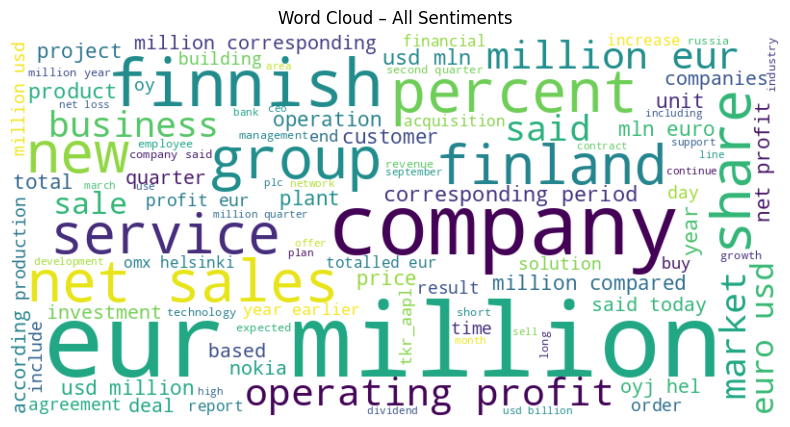

In [66]:
all_text = " ".join(df["text_clean"].dropna())
wc = WordCloud(width=800, height=400, background_color="white",
               colormap="viridis", max_words=100).generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – All Sentiments")
plt.show()

**Analisis Word Cloud (All Sentiments)**

1. **Token dominan**
- Kata yang paling besar → “eur”, “million”, “company” → menunjukkan bahwa hampir semua berita finansial berfokus pada nilai mata uang Euro, skala besar (million), dan laporan perusahaan.
- Kata kuat lain: “percent”, “net sales”, “operating profit”, “share”, “business”, “market” → istilah finansial inti yang selalu muncul dalam berita.

2. **Konteks geografis & sektoral**
- Kata “finnish”, “finland”, “nokia” → menunjukkan dataset banyak mengandung berita perusahaan Eropa, khususnya Finlandia.
- Kata “service”, “group”, “product”, “project” → menggambarkan cakupan bisnis yang dilaporkan.

3. **Kata kuantitatif & evaluatif**
- Banyak angka yang direpresentasikan dalam bentuk kata: “percent”, “million”, “net sales”, “operating profit” → menandakan berita finansial sangat kuantitatif.
- Kata “share, market, growth, revenue, loss” → memunculkan nuansa evaluasi terhadap kinerja.

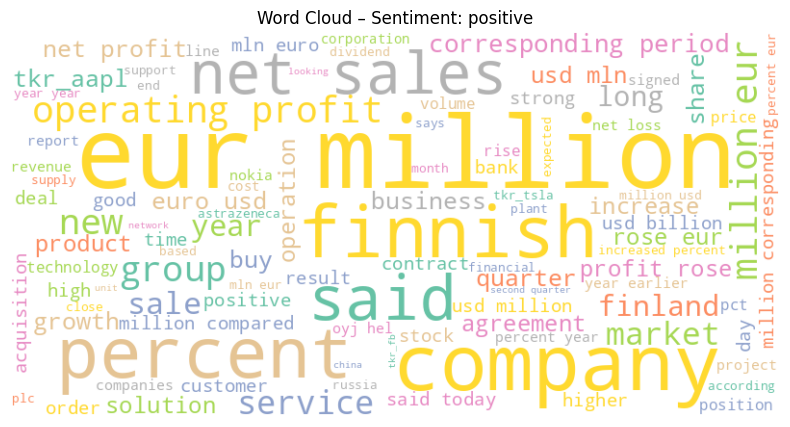

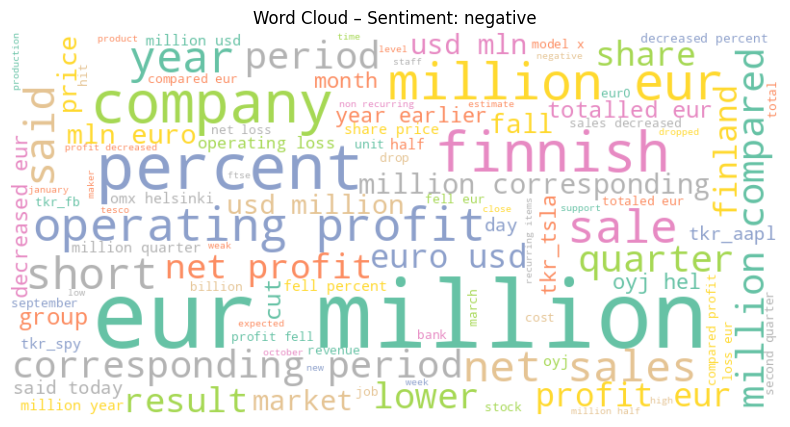

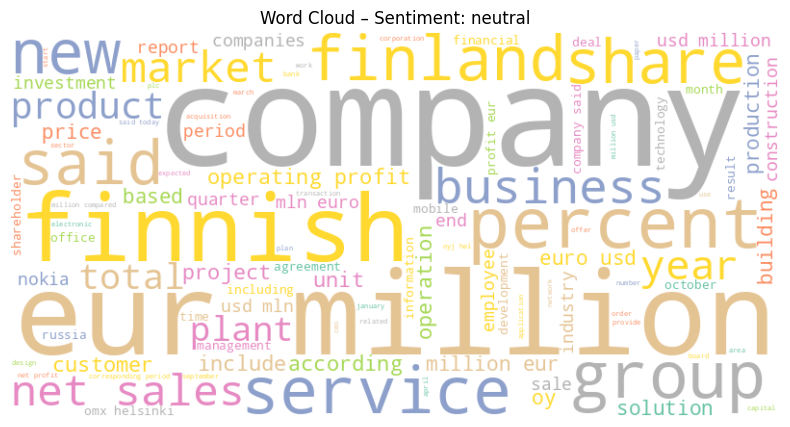

In [67]:
labels = df[LABEL_COL].unique()

for lab in labels:
    text = " ".join(df[df[LABEL_COL]==lab]["text_clean"].dropna())
    wc = WordCloud(width=800, height=400, background_color="white",
                   colormap="Set2", max_words=100).generate(text)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud – Sentiment: {lab}")
    plt.show()


1. **Positive**
- Dominan: eur, million, percent, operating profit, net sales, company.
- Kata tambahan khas positif: growth, increase, rose, new, market, group.
- Insight: Kata yang muncul banyak menekankan optimisme dan pertumbuhan (contoh: increase, growth, rose) → sesuai dengan karakter label positif yang menyoroti keberhasilan, kinerja baik, atau peluang kenaikan pasar.

2. **Negative**
- Dominan: tetap eur, million, percent, company, operating profit.
- Khas negatif: decreased, lower, short, fell, loss, cut.
- Insight: Perbedaannya dari label positif bukan pada token finansial utama, melainkan pada kata evaluatif bernuansa penurunan. Frasa seperti “profit decreased”, “sales fell”, atau “loss” menjadi penanda jelas adanya kinerja buruk atau kerugian.

3. **Neutral**
- Dominan: eur, million, percent, company, service, business, group, finland, finnish.
- Kata khas netral: said, according, total, building, production, project.
- Insight: Berita netral lebih banyak berupa bahasa deskriptif dan laporan faktual (contoh: “company said”, “according to report”) tanpa kata emosional seperti increase atau decreased. Hal ini menunjukkan sifat informatif, bukan evaluatif.

### **Text Conversion**

In [68]:
df["Sentiment"].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

- df["Sentiment"].unique() → Mengecek semua kategori unik yang ada di kolom Sentiment.
- Output: ['positive', 'negative', 'neutral'] → Berarti dataset hanya memiliki 3 kelas.

In [69]:
# mapping string → angka (ubah urutan kalau kamu mau)
label_map = {"negative": 0, "neutral": 1, "positive": 2}

df["label"] = df["Sentiment"].str.strip().str.lower().replace(label_map)
df[[ "Sentence", "text_clean", "Sentiment", "label" ]].head()

/tmp/ipython-input-2738531952.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["label"] = df["Sentiment"].str.strip().str.lower().replace(label_map)


,Sentence,text_clean,Sentiment,label
0,The GeoSolutions technology will leverage Bene...,geosolutions technology leverage benefon gps s...,positive,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",tkr_esi lows usd 1 50 usd 2 50 bk real possibi...,negative,0
2,"For the last quarter of 2010 , Componenta 's n...",quarter 2010 componenta net sales doubled eur1...,positive,2
3,According to the Finnish-Russian Chamber of Co...,according finnish russian chamber commerce maj...,neutral,1
4,The Swedish buyout firm has sold its remaining...,swedish buyout firm sold remaining 22 4 percen...,neutral,1


1. ``label_map`` mendefinisikan mapping label text → angka:
  - negative → 0
  - neutral → 1
  - positive → 2

2. ``df["label"]`` membuat kolom baru berisi label numerik dengan cara:
  - str.strip() → buang spasi di awal/akhir.
  - str.lower() → konsistensi ke lowercase.
  - .replace(label_map) → ganti string dengan angka sesuai dictionary.

3. ``.head()`` → preview hasil untuk cek apakah mapping sudah benar.

**Objective**
1. Mengubah label teks (kategori) menjadi bentuk numerik agar bisa digunakan model machine learning (ANN, LSTM, BERT, dll).
2. Menjamin konsistensi label sehingga tidak ada variasi seperti “Positive” vs “positive”.
3. Membuat dataset siap dipakai untuk proses training klasifikasi multi-class.

In [70]:
df["label"].value_counts()

,count
label,
1,3130
2,1852
0,860


Menghitung jumlah data di tiap kelas setelah konversi ke angka.
- Hasil:
    - Label 1 (neutral): 3130 data (53,6%)
    - Label 2 (positive): 1852 data (31,7%)
    - Label 0 (negative): 860 data (14,7%)

### **Split Train Test and Val**

In [71]:
# fitur = text_clean, target = label
X = df["text_clean"].values
y = df["label"].values

# test split 15%
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=20, stratify=y
)

# val split 10% dari trainval
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.10, random_state=20, stratify=y_trainval
)

print("Train Size :", X_train.shape)
print("Val Size   :", X_val.shape)
print("Test Size  :", X_test.shape)

Train Size : (4468,)
Val Size   : (497,)
Test Size  : (877,)


1. **Definisi fitur dan target**
    - X = df["text_clean"].values → mengambil teks yang sudah dibersihkan.
    - y = df["label"].values → mengambil label yang sudah dikonversi ke angka.
2. **Split Test Set (15%)**
    - train_test_split(..., test_size=0.15, stratify=y)
    - → 15% data dipakai sebagai test set. Stratify memastikan distribusi kelas tetap seimbang.
3. **Split Validation Set (10% dari trainval)**
    - Sisa 85% data dibagi lagi: 10% untuk validasi, sisanya untuk training.
    - Hasil akhir: Train ~76.5%, Val ~8.5%, Test 15%.
4. **Output ukuran data**
    - Train Size: 4468 data
    - Val Size: 497 data
    - Test Size: 877 data

### **Text Vectorization**

In [72]:
# 1) DATA: pakai teks mentah yg sudah dibersihkan
X_train = np.asarray(X_train, dtype=str)   # 1D array of strings
X_val   = np.asarray(X_val,   dtype=str)
X_test  = np.asarray(X_test,  dtype=str)

# 2) Tentukan panjang sequence & vocab (boleh pakai nilai tetap)
MAX_LEN     = max(len(s.split()) for s in X_train)   # atau set 64/128
VOCAB_SIZE  = 20000                                   # atau None (ambil semua)

# 3) Buat TextVectorization
text_vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=None,         # kamu sudah cleaning sendiri
    split="whitespace",
    output_mode="int",
    output_sequence_length=MAX_LEN,
)

- Ubah semua data (train/val/test) ke array string 1D → supaya kompatibel dengan layer TextVectorization.
- MAX_LEN: cari jumlah kata maksimum di data train (jadi panjang sequence input).
- VOCAB_SIZE: batasi jumlah kata unik → kontrol kompleksitas model.
- Tentukan aturan vectorizer: tokenisasi by whitespace, output integer, padding/truncating sesuai MAX_LEN.
- Adaptasi hanya pakai train set → bangun daftar kata unik (hindari data leakage).

In [73]:
# 4) Adapt HANYA di TRAIN (pakai teks, bukan sparse)
text_vectorization.adapt(tf.data.Dataset.from_tensor_slices(X_train).batch(256))

# (Opsional) Preview
print("Contoh dokumen:", X_train[0][:120])
print("Top-20 token:", text_vectorization.get_vocabulary()[:20])

Contoh dokumen: lassila tikanoja operating profit excluding non recurring imputed items second quarter eur11 3 million eur13 8 million y
Top-20 token: ['', '[UNK]', np.str_('million'), np.str_('eur'), np.str_('company'), np.str_('percent'), np.str_('profit'), np.str_('sales'), np.str_('finnish'), np.str_('1'), np.str_('said'), np.str_('year'), np.str_('usd'), np.str_('net'), np.str_('3'), np.str_('2'), np.str_('5'), np.str_('operating'), np.str_('0'), np.str_('quarter')]


- Print contoh dokumen asli.
- Tampilkan 20 token teratas hasil adaptasi untuk validasi.

### **Word Embedding**

In [74]:
# ambil ukuran vocab & panjang sequence langsung dari layer vectorizer
vocab_size = len(text_vectorization.get_vocabulary())
max_len    = text_vectorization.get_config()["output_sequence_length"]

embedding_dim = 128

embedding = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    embeddings_initializer="uniform"
)

Objective dari kode ini adalah menyiapkan layer embedding dengan ukuran kosakata (vocab_size) dan panjang sequence (max_len) dari hasil TextVectorization, lalu memetakan setiap kata ke vektor berdimensi 128 agar teks bisa diproses model lebih efektif.

In [75]:
# cek 1 contoh dokumen (pakai text_clean)
doc = X_train[0]  # X_train berisi df["text_clean"] setelah split

print('Document example')
print(doc); print('')

print('Result of Text Vectorization')
vec = text_vectorization([doc])
print(vec)
print('Vector size :', vec.shape); print('')

print('Result of Embedding')
emb = embedding(vec)
print(emb)
print('Embedding shape :', emb.shape)   # (1, max_len, embedding_dim)

Document example
lassila tikanoja operating profit excluding non recurring imputed items second quarter eur11 3 million eur13 8 million year ago

Result of Text Vectorization
tf.Tensor(
[[1253 1204   17    6  281  179  263 3930  216   66   19 2311   14    2
  1143   33    2   11  298    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]], shape=(1, 48), dtype=int64)
Vector size : (1, 48)

Result of Embedding
tf.Tensor(
[[[-0.03173538 -0.03653478 -0.01751692 ... -0.02564885  0.00866901
   -0.01990024]
  [ 0.01700517  0.02443392  0.04341059 ...  0.01292357  0.00813576
    0.03360884]
  [-0.00136566 -0.00297106  0.04445218 ...  0.00796375  0.00652919
   -0.0109743 ]
  ...
  [-0.03008774 -0.03869172  0.0325997  ... -0.02159899 -0.02405407
   -0.00367845]
  [-0.03008774 -0.03869172  0.0325997  ... -0.02159899 -0.02405407
   -0.00367845]
  [-0.03008774 -0.03869172  0.0325997  ... -0.02159899 -0.02

## **Model Baseline**

### **Model Definition**

In [76]:
X_train_ids = text_vectorization(X_train)
X_val_ids   = text_vectorization(X_val)
X_test_ids  = text_vectorization(X_test)

print(X_train_ids.shape, X_val_ids.shape, X_test_ids.shape)

(4468, 48) (497, 48) (877, 48)


**Flow Kode**
1. ``text_vectorization(X_train)`` → mengubah teks training menjadi urutan indeks token.
2. ``text_vectorization(X_val)`` → melakukan hal sama untuk data validasi.
3. ``text_vectorization(X_test)`` → melakukan hal sama untuk data testing.
4. ``print(...shape)`` → menampilkan ukuran hasil vectorization:
    - Train: (4468, 48)
    - Val: (497, 48)
    - Test: (877, 48)

**Objective**
- Mengonversi teks mentah menjadi representasi numerik tetap (48 token per kalimat) agar bisa dipakai sebagai input model ANN.

In [77]:
# ubah label (integer) jadi one-hot
y_train_ohe = to_categorical(y_train)
y_val_ohe   = to_categorical(y_val)
y_test_ohe  = to_categorical(y_test)

print("y_train_ohe shape:", y_train_ohe.shape)
print("y_val_ohe shape :", y_val_ohe.shape)
print("y_test_ohe shape:", y_test_ohe.shape)

y_train_ohe shape: (4468, 3)
y_val_ohe shape : (497, 3)
y_test_ohe shape: (877, 3)


**Flow Kode**
1. to_categorical(y_train/y_val/y_test) → mengubah label integer (0,1,2) menjadi format one-hot encoding (vektor biner).
2. y_train_ohe.shape = (4468, 3) → berarti ada 4468 sampel, masing-masing dengan representasi 3 kelas.
3. y_val_ohe.shape = (497, 3) → ada 497 sampel untuk validasi, tiap label diubah jadi vektor one-hot dengan 3 kolom.
4. y_test_ohe.shape = (877, 3) → sama untuk data uji, total 877 sampel.

**Objective**
- Agar label bisa diproses oleh model neural network dengan benar, setiap kelas (negative, neutral, positive) diubah menjadi representasi one-hot 3 dimensi, sehingga output layer model bisa cocok dengan format klasifikasi multi-kelas.

In [ ]:
vocab_size = len(text_vectorization.get_vocabulary())
max_len    = text_vectorization.get_config()["output_sequence_length"]
embedding_dim = 128

# clear session + seed
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

model_lstm_1 = Sequential()

# nlp stack (input = token ids, panjang = max_len)
model_lstm_1.add(Input(shape=(max_len,)))
model_lstm_1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))

model_lstm_1.add(Bidirectional(LSTM(32, return_sequences=True,
                                    kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))

model_lstm_1.add(Bidirectional(LSTM(16, return_sequences=True,
                                    kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))

model_lstm_1.add(Bidirectional(LSTM(16, return_sequences=False,
                                    kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))

# ann stack 'this would make the model more balanced'
model_lstm_1.add(Dense(10, activation='relu'))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(5, activation='relu'))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(3, activation='softmax'))   # 3 kelas

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 48, 128)        │     1,222,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 48, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 48, 32)         │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,659 (4.89 MB)

 Trainable params: 1,280,659 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

**Setup**
1. seed = 20 untuk hasil yang reprodusibel.
2. vocab_size = len(text_vectorization.get_vocabulary())
3. max_len = text_vectorization.get_config()['output_sequence_length']
4. embedding_dim = 128

**Arsitektur (Sequential)**
1. Input(shape=(max_len,))
    - Masukan berupa deretan token id panjang tetap (max_len).
2. Embedding(input_dim=vocab_size, output_dim=128)
    - Mengubah setiap token id → vektor 128-dim. Belajar representasi kata selama training.
3. BiLSTM(32, return_sequences=True) + Dropout(0.1)
    - Menangkap konteks dua arah (kiri→kanan & kanan→kiri) di level awal; return_sequences=True supaya keluaran per‐time step diteruskan ke layer LSTM berikutnya.
4. BiLSTM(16, return_sequences=True) + Dropout(0.1)
    - Penyempurnaan pola berurutan (lebih kecil → regularisasi & efisien); masih keluarkan urutan penuh.
5. BiLSTM(16, return_sequences=False) + Dropout(0.1)
    - Layer rangkuman: hanya keluarkan vektor terakhir (representasi keseluruhan kalimat).
6. Dense(10, activation='relu') + Dropout(0.1)
    - Proyeksi non-linear pertama untuk fitur ringkasan sekuens.
7. Dense(5, activation='relu') + Dropout(0.1)
    - Penyempurnaan fitur sebelum klasifikasi akhir.
8. Dense(3, activation='softmax')
    - Output probabilitas untuk 3 kelas (negative, neutral, positive).

**Kompilasi**
- loss='categorical_crossentropy' (karena label one-hot 3 kelas).
- optimizer='adam'.
- metrics=['accuracy'].

### **Model Training**

In [79]:
class F1Callback(tf.keras.callbacks.Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data   = val_data
        self.f1_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        # --- TRAIN ---
        y_prob_tr = self.model.predict(self.train_data[0], verbose=0)
        y_pred_tr = y_prob_tr.argmax(axis=1)
        y_true_tr = self.train_data[1].argmax(axis=1)
        f1_tr = f1_score(y_true_tr, y_pred_tr, average="macro")

        # --- VAL ---
        y_prob_va = self.model.predict(self.val_data[0], verbose=0)
        y_pred_va = y_prob_va.argmax(axis=1)
        y_true_va = self.val_data[1].argmax(axis=1)
        f1_va = f1_score(y_true_va, y_pred_va, average="macro")

        # simpan ke logs → masuk ke history.history
        logs["f1"] = f1_tr
        logs["val_f1"] = f1_va

        # simpan manual juga (cadangan)
        self.f1_scores.append(f1_tr)
        self.val_f1_scores.append(f1_va)

**Flow Kode**
1. Class F1Callback dibuat → turunan dari tf.keras.callbacks.Callback untuk custom metric.
2. __init__ → menyimpan data train & validation, menyiapkan list kosong untuk menyimpan skor F1 tiap epoch.
3. on_epoch_end → dijalankan setiap akhir epoch:
    - Prediksi data train & val (self.model.predict).
    - Ambil label asli (y_true) dan prediksi (y_pred).
    - Hitung skor F1 macro dengan f1_score().
    - Simpan ke logs → supaya masuk ke history.history.
    - Simpan manual ke list (self.f1_scores, self.val_f1_scores) sebagai cadangan.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)

f1_cb = F1Callback(
    train_data=(X_train_ids, y_train_ohe),
    val_data=(X_val_ids,  y_val_ohe)
)

history = model_lstm_1.fit(
    X_train_ids, y_train_ohe,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_ids, y_val_ohe),
    callbacks=[early_stop, reduce_lr, f1_cb],
    verbose=1
)

history.history["f1"]     = f1_cb.f1_scores
history.history["val_f1"] = f1_cb.val_f1_scores

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 33s 308ms/step - accuracy: 0.3349 - loss: 1.0707 - val_accuracy: 0.3199 - val_loss: 1.0237 - learning_rate: 0.0010 - f1: 0.1607 - val_f1: 0.1636
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 34s 206ms/step - accuracy: 0.4055 - loss: 1.0053 - val_accuracy: 0.5352 - val_loss: 0.9324 - learning_rate: 0.0010 - f1: 0.2326 - val_f1: 0.2324
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step - accuracy: 0.5296 - loss: 0.8625 - val_accuracy: 0.5111 - val_loss: 0.9946 - learning_rate: 0.0010 - f1: 0.4605 - val_f1: 0.3217
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.5605 - loss: 0.8013 - val_accuracy: 0.5010 - val_loss: 1.0758 - learning_rate: 0.0010 - f1: 0.4634 - val_f1: 0.2876
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 230ms/step - accuracy: 0.5552 - loss: 0.7816 - val_accuracy: 0.4889 - val_loss: 1.0966 - learning_rate: 5.0000e-04 - f1: 0.4851 - val_f1: 0.3038


1. Accuracy train naik dari 0.33 → 0.55.
2. F1 train naik dari 0.16 → 0.48.
3. Validation F1 tetap rendah sekitar 0.23–0.32.




### **Model Evaluation**

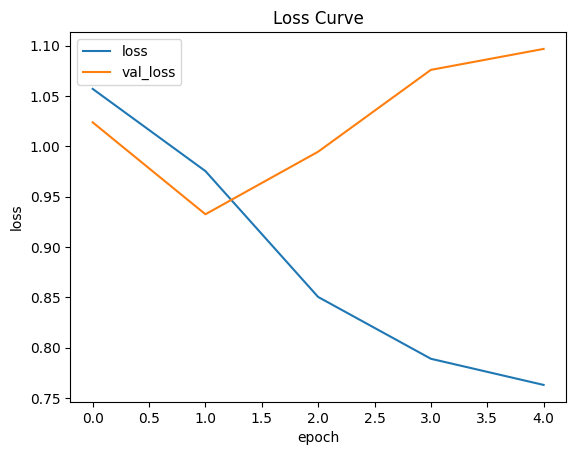

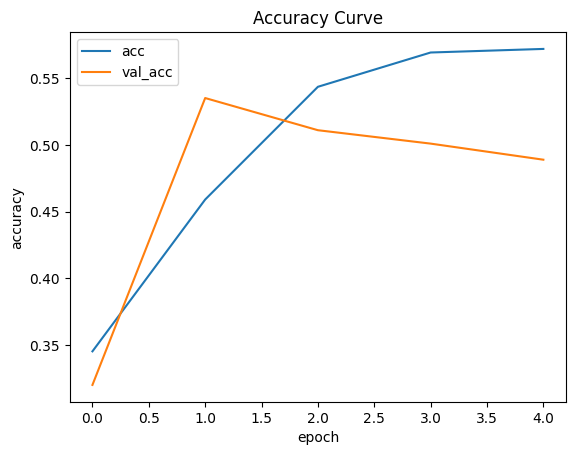

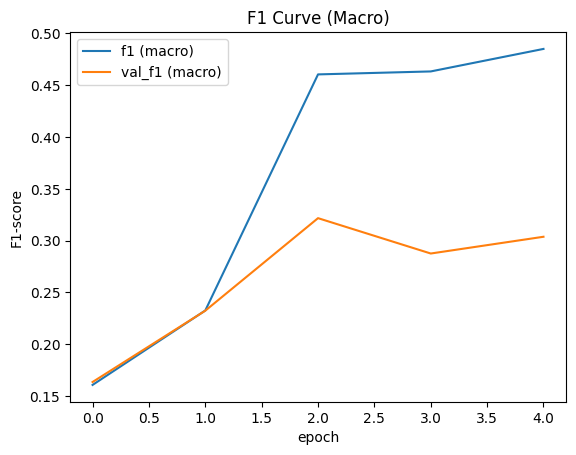

In [82]:
# Loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('Loss Curve'); plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.title('Accuracy Curve'); plt.show()

# F1 (macro) → train vs val
plt.plot(history.history['f1'], label='f1 (macro)')
plt.plot(history.history['val_f1'], label='val_f1 (macro)')
plt.xlabel('epoch'); plt.ylabel('F1-score'); plt.legend(); plt.title('F1 Curve (Macro)'); plt.show()

1. **Loss**
- Train Loss turun dari 1.05 → 0.76 hingga epoch ke-4.
- Val Loss awalnya 1.02, sempat turun ke 0.93 (epoch 1), lalu naik lagi hingga 1.09 (epoch 4).
- Interpretasi: model belajar dengan baik di training set, tapi pada validation set cenderung naik → indikasi overfitting sejak epoch ke-2.
2. **Accuracy**
- Train Accuracy naik dari 0.34 → 0.57 pada epoch ke-4.
- Val Accuracy sempat melonjak ke 0.53 (epoch 1), lalu menurun ke 0.49 (epoch 4).
- Interpretasi: model cukup mampu belajar di training, tapi validasi tidak stabil, akurasi malah menurun → mendukung indikasi overfitting.
3. **F1 Score (Macro) → Metrik Utama**
- Train F1 Macro naik tajam dari 0.16 → 0.48 pada epoch ke-4.
- Val F1 Macro meningkat ke 0.32 (epoch 2), kemudian turun ke 0.30 (epoch 4).
- Interpretasi: meski training F1 meningkat cukup tinggi, validasi F1 rendah dan stagnan. Ini berarti generalization buruk: model belum bisa menangani semua kelas secara seimbang di data validasi.

In [83]:
# evaluate
test_loss, test_acc = model_lstm_1.evaluate(X_test_ids, y_test_ohe, verbose=0)
y_proba = model_lstm_1.predict(X_test_ids, verbose=0)
y_pred  = y_proba.argmax(axis=1)
y_true  = y_test_ohe.argmax(axis=1)

macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Test Acc: {test_acc:.4f} | Test Loss: {test_loss:.4f} | Macro-F1: {macro_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['negative','neutral','positive'], digits=4))

Test Acc: 0.5359 | Test Loss: 0.8988 | Macro-F1: 0.2326

Classification Report:
              precision    recall  f1-score   support

    negative     0.0000    0.0000    0.0000       129
     neutral     0.5359    1.0000    0.6978       470
    positive     0.0000    0.0000    0.0000       278

    accuracy                         0.5359       877
   macro avg     0.1786    0.3333    0.2326       877
weighted avg     0.2872    0.5359    0.3740       877



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1. **Akurasi dan Loss**
    - Akurasi pada data uji mencapai 0.5359 (53.59%), dengan Test Loss sebesar 0.8988.
    -  Nilai akurasi menunjukkan model hanya sedikit lebih baik dari random guess (karena dataset terdiri dari 3 kelas → baseline random sekitar 33%).

2. **F1 Macro (Metrik Utama)**
    - Nilai Macro-F1 = 0.2326, yang rendah dan menjadi indikator bahwa model gagal menyeimbangkan performa antar kelas.
    - Hal ini terjadi karena model hanya fokus pada kelas tertentu (dominan) sehingga kelas lain terabaikan.

3. **Performa per Kelas**
    - Negative: precision = 0.0000, recall = 0.0000, F1 = 0.0000 → model sama sekali tidak mengenali kelas negatif.
    - Neutral: precision = 0.5359, recall = 1.0000, F1 = 0.6978 → hampir semua prediksi diarahkan ke kelas netral.
    - Positive: precision = 0.0000, recall = 0.0000, F1 = 0.0000 → kelas positif juga tidak berhasil diprediksi.

4. **Macro vs Weighted Average**
    - Macro average (rata-rata sederhana antar kelas) → precision 0.1786, recall 0.3333, F1 0.2326. Nilai rendah karena ketidakseimbangan performa antar kelas.
    - Weighted average → precision 0.2872, recall 0.5359, F1 0.3740. Lebih tinggi karena dipengaruhi oleh jumlah besar kelas netral yang mendominasi prediksi.

<Figure size 600x500 with 0 Axes>

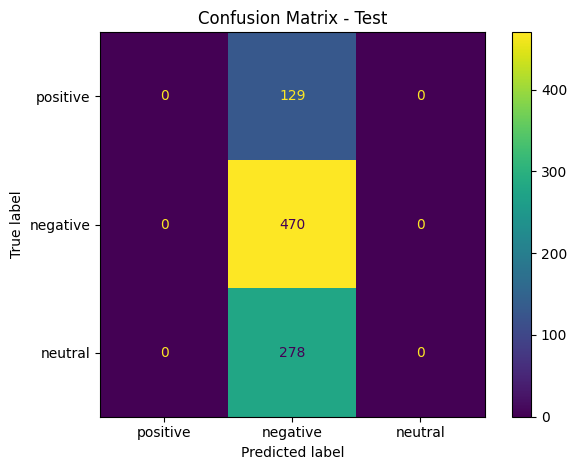

In [84]:
cm  = confusion_matrix(y_true, y_pred, labels=[0,1,2])
disp = ConfusionMatrixDisplay(cm, display_labels=labels)

plt.figure(figsize=(6,5))
disp.plot(values_format='d', cmap='viridis', colorbar=True)
plt.title('Confusion Matrix - Test')
plt.xlabel('Predicted label'); plt.ylabel('True label')
plt.tight_layout(); plt.show()

Analisis Confusion Matrix
1. Kelas Positive
    - True Positive = 0
    - False Predicted ke Negative = 129
    - False Predicted ke Neutral = 0
    - Semua sampel positif (129 data) diprediksi sebagai negative, sehingga precision, recall, dan F1 untuk kelas ini = 0.000.

2. Kelas Negative
    - True Negative = 470
    - False Predicted ke Positive = 0
    - False Predicted ke Neutral = 0
    - Model mengenali seluruh kelas negative dengan benar (akurasi 100% di kelas ini).

3. Kelas Neutral
    - True Neutral = 0
    - False Predicted ke Negative = 278
    - False Predicted ke Positive = 0
    - Semua data neutral (278 data) diprediksi salah menjadi negative, sehingga metriknya juga 0.000.

## **Modelling Improvement**

### **Model Definition**

In [ ]:
# ===== context & flags =====
vocab_size = len(text_vectorization.get_vocabulary())
max_len    = text_vectorization.get_config()["output_sequence_length"]

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed); tf.random.set_seed(seed)

BASE_LR        = 3e-4      
USE_OVERSAMPLE = False     
LOSS_KIND      = "ce"      
EXP            = "A1"

**Flow Kode**

1. Hitung vocab & sequence length
    - ``vocab_size`` = jumlah token unik dari TextVectorization.
    - ``max_len`` = panjang maksimal sequence yang dihasilkan.

2. Set seed & clear session
    - Reset backend Keras (clear_session) agar model training stabil.
    - Atur np.random.seed dan tf.random.set_seed supaya hasil bisa direproduksi.

3. Definisi hyperparameter/flags
    - ``BASE_LR = 3e-4`` → learning rate default.
    - ``USE_OVERSAMPLE`` = False → mulai tanpa oversampling biar baseline stabil.   
    - ``LOSS_KIND`` = "ce" → jenis loss function: categorical crossentropy.
    - ``EXP`` = "A1" → penanda eksperimen.

**Objective**
- Cell ini berfungsi sebagai setup eksperimen: memastikan environment bersih, reproducible, serta menyimpan konfigurasi dasar (vocab, panjang sequence, learning rate, dan opsi training) sebelum mendefinisikan arsitektur model.

In [ ]:
# focal loss

def focal_loss(gamma=2.0, alpha=None):
    if alpha is not None:
        alpha = tf.constant(alpha, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())
        ce = -y_true * tf.math.log(y_pred)
        fw = tf.pow(1.0 - y_pred, gamma)
        fl = fw * ce
        if alpha is not None:
            fl = fl * alpha
        return tf.reduce_sum(fl, axis=-1)
    return loss_fn

ALPHA = None   

**Flow Kode – Focal Loss**
1. Definisi fungsi focal_loss
    - Parameter utama:
        - gamma=2.0: mengatur seberapa besar penalti untuk sampel mudah (semakin besar gamma → semakin fokus ke sampel sulit).
        - alpha=None: opsional untuk memberi bobot berbeda per kelas jika dataset imbalanced.

2. Inisialisasi alpha (opsional)
    - Jika alpha tidak kosong → diubah jadi tf.constant agar bisa dipakai dalam operasi tensor.

3. Definisi fungsi loss_fn(y_true, y_pred)
    - y_pred = tf.clip_by_value(...) → memastikan prediksi tidak keluar dari [ε, 1-ε], mencegah log(0).
    - ce = -y_true * tf.math.log(y_pred) → menghitung cross-entropy dasar.
    - fw = tf.pow(1.0 - y_pred, gamma) → faktor fokus; memberi bobot lebih besar pada kesalahan.
    - fl = fw * ce → focal loss = cross entropy * fokus.
    - Jika ada alpha, hasil dikalikan dengan bobot per kelas.

4. Return
    - tf.reduce_sum(fl, axis=-1) → menjumlahkan loss untuk setiap sampel.
    - Fungsi loss_fn dikembalikan sebagai custom loss.


**Objective**
- Tujuan kode ini adalah membuat custom focal loss untuk mengatasi masalah class imbalance dan meningkatkan fokus model pada data sulit. Dengan parameter γ (gamma), model lebih menekankan pada prediksi yang salah, sedangkan α (alpha) (jika diisi) membantu menyeimbangkan kontribusi tiap kelas agar kelas minoritas tidak terabaikan.

In [87]:
def build_A1(emb=128, rd=0.1, dp=0.1, lr=BASE_LR, loss_kind=LOSS_KIND):
    tf.keras.backend.clear_session(); np.random.seed(seed); tf.random.set_seed(seed)
    m = Sequential()
    m.add(Input(shape=(max_len,)))
    m.add(Embedding(vocab_size, emb))
    m.add(Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=rd,
                             kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
    m.add(Dropout(dp))
    m.add(Bidirectional(LSTM(16, return_sequences=False, recurrent_dropout=rd,
                             kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
    m.add(Dropout(dp))
    m.add(Dense(32, activation='relu')); m.add(Dropout(dp))
    m.add(Dense(3, activation='softmax'))
    loss_fn = 'categorical_crossentropy' if loss_kind=='ce' else focal_loss(gamma=2.0, alpha=ALPHA)
    m.compile(optimizer=Adam(lr, clipnorm=1.0), loss=loss_fn, metrics=['accuracy'])
    return m

def build_A2(emb=256, rd=0.2, dp=0.2, lr=BASE_LR, loss_kind=LOSS_KIND):
    tf.keras.backend.clear_session(); np.random.seed(seed); tf.random.set_seed(seed)
    m = Sequential()
    m.add(Input(shape=(max_len,)))
    m.add(Embedding(vocab_size, emb))
    m.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=rd,
                             kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
    m.add(Dropout(dp))
    m.add(Bidirectional(LSTM(32, return_sequences=False, recurrent_dropout=rd,
                             kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
    m.add(Dropout(dp))
    m.add(Dense(64, activation='relu')); m.add(Dropout(dp))
    m.add(Dense(3, activation='softmax'))
    loss_fn = 'categorical_crossentropy' if loss_kind=='ce' else focal_loss(gamma=2.0, alpha=ALPHA)
    m.compile(optimizer=Adam(lr, clipnorm=1.0), loss=loss_fn, metrics=['accuracy'])
    return m

def build_A3(emb=128, rd=0.1, dp=0.1, lr=BASE_LR, loss_kind=LOSS_KIND):
    tf.keras.backend.clear_session(); np.random.seed(seed); tf.random.set_seed(seed)
    m = Sequential()
    m.add(Input(shape=(max_len,)))
    m.add(Embedding(vocab_size, emb))
    m.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=rd,
                             kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
    m.add(GlobalMaxPooling1D())
    m.add(Dropout(dp))
    m.add(Dense(32, activation='relu')); m.add(Dropout(dp))
    m.add(Dense(3, activation='softmax'))
    loss_fn = 'categorical_crossentropy' if loss_kind=='ce' else focal_loss(gamma=2.0, alpha=ALPHA)
    m.compile(optimizer=Adam(lr, clipnorm=1.0), loss=loss_fn, metrics=['accuracy'])
    return m

**Bagian umum (semua model)**
- Input: urutan token dengan panjang tetap max_len.
- Embedding: Embedding(vocab_size, emb) mengubah token → vektor (dimensi emb).
- Klasifikasi: Dense(32, relu) → Dropout(dp) → Dense(3, softmax) (3 kelas).
- Optimisasi: Adam(learning_rate=lr, clipnorm=1.0); loss bisa categorical_crossentropy atau focal_loss(gamma=2.0, alpha=ALPHA) sesuai loss_kind.
- Regularisasi: Dropout(dp) di beberapa titik; recurrent_dropout=rd pada LSTM.
- Seed diset (TF/NumPy) supaya hasil re-producible.

**A1 — Shallow BiLSTM stack (ringan, cepat)**
- Embedding: emb=128 (default).
- RNN: BiLSTM(32, return_sequences=True) → Dropout(0.1) → BiLSTM(16, return_sequences=False) → Dropout(0.1).
- Kapan dipilih: baseline cepat, parameter ringan, cocok saat ingin iterasi cepat atau device terbatas.

**A2 — Deeper / lebih lebar (kapasitas lebih besar)**
- Embedding: emb=256.
- RNN: BiLSTM(64, return_sequences=True) → Dropout(0.2) → BiLSTM(32, return_sequences=False) → Dropout(0.2).
- Kapan dipilih: data lebih kompleks; butuh kapasitas representasi lebih besar dengan regularisasi lebih kuat.

**A3 — BiLSTM + GlobalMaxPooling (sederhana & robust)**
- Embedding: emb=128.
- RNN + Pooling: BiLSTM(64, return_sequences=True) → GlobalMaxPooling1D() → Dropout(0.1).
- Kapan dipilih: ingin merangkum fitur urutan secara global (max-pool) dan mengurangi overfitting/biaya komputasi dibanding stack dua LSTM.

In [88]:
if EXP == "A1":
    model = build_A1()
elif EXP == "A2":
    model = build_A2()
elif EXP == "A3":
    model = build_A3()
else:
    raise ValueError("EXP must be 'A1' / 'A2' / 'A3'.")

print("Experiment:", EXP, "| LOSS:", LOSS_KIND, "| OVERSAMPLE:", USE_OVERSAMPLE)
model.summary()


Experiment: A1 | LOSS: ce | OVERSAMPLE: False


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 48, 128)        │     1,222,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 48, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,275,139 (4.86 MB)

 Trainable params: 1,275,139 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

**Flow Kode: Pemilihan Arsitektur Model**
1. Pemilihan eksperimen (EXP)
    - Jika EXP == "A1" → model dibangun dengan fungsi build_A1().
    - Jika EXP == "A2" → model dibangun dengan fungsi build_A2().
    - Jika EXP == "A3" → model dibangun dengan fungsi build_A3().
    - Jika tidak sesuai → muncul error (ValueError).

2. Print konfigurasi eksperimen
    - Menampilkan nama eksperimen, jenis loss yang digunakan (ce atau focal), serta status oversample (True/False).

3. Model summary
    - Menampilkan ringkasan layer model yang sudah dipilih sesuai eksperimen.

### **Model Training**

In [89]:
if USE_OVERSAMPLE:
    y_int = y_train
    i0, i1, i2 = np.where(y_int==0)[0], np.where(y_int==1)[0], np.where(y_int==2)[0]
    n = max(len(i0), len(i1), len(i2))
    sel = np.concatenate([
        np.random.choice(i0, n, True),
        np.random.choice(i1, n, True),
        np.random.choice(i2, n, True)
    ])
    np.random.shuffle(sel)
    X_tr = tf.gather(X_train_ids, sel)
    y_tr = y_train_ohe[sel]
else:
    X_tr = X_train_ids
    y_tr = y_train_ohe
print("train size:", X_tr.shape[0])


train size: 4468


**Flow Kode: Oversampling Data Training**

1. Cek Opsi Oversampling
    - Jika USE_OVERSAMPLE = True, sistem akan menjalankan proses oversampling.
    - Jika USE_OVERSAMPLE = False, data training digunakan apa adanya tanpa penyeimbangan.
2. Identifikasi Indeks per Kelas
    - i0 = indeks data dengan label 0 (negative).
    - i1 = indeks data dengan label 1 (neutral).
    - i2 = indeks data dengan label 2 (positive).
3. Hitung Jumlah Target per Kelas
    - n = max(len(i0), len(i1), len(i2)) → menentukan ukuran terbesar di antara ketiga kelas.
    - Tujuannya agar kelas minoritas ditingkatkan (oversample) hingga seimbang dengan kelas mayoritas.
4. Proses Oversampling
    - np.random.choice(i0, n, True) → sampling ulang dari kelas 0 hingga berjumlah n.
    - np.random.choice(i1, n, True) → sampling ulang dari kelas 1.
    - np.random.choice(i2, n, True) → sampling ulang dari kelas 2.
    - Hasil tiga sampling digabung (np.concatenate).
5. Shuffle Indeks
    - Indeks hasil oversampling diacak (np.random.shuffle(sel)) agar distribusi data tidak berurutan.
6. Bangun Data Training Baru
    - X_tr = tf.gather(X_train_ids, sel) → pilih ulang data fitur sesuai indeks sel.
    - y_tr = y_train_ohe[sel] → pilih ulang label (sudah one-hot).
7. Jika Tidak Oversample
    - X_tr = X_train_ids
    - y_tr = y_train_ohe
    - Artinya data training digunakan langsung tanpa penyeimbangan.
8. Output
    - print("train size:", X_tr.shape[0]) → menampilkan jumlah data training akhir.

In [90]:
class F1Callback(tf.keras.callbacks.Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data   = val_data
        self.f1_scores = []
        self.val_f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        # --- TRAIN ---
        y_prob_tr = self.model.predict(self.train_data[0], verbose=0)
        y_pred_tr = y_prob_tr.argmax(axis=1)
        y_true_tr = self.train_data[1].argmax(axis=1)
        f1_tr = f1_score(y_true_tr, y_pred_tr, average="macro")

        # --- VAL ---
        y_prob_va = self.model.predict(self.val_data[0], verbose=0)
        y_pred_va = y_prob_va.argmax(axis=1)
        y_true_va = self.val_data[1].argmax(axis=1)
        f1_va = f1_score(y_true_va, y_pred_va, average="macro")

        # taruh ke logs → history.history['f1'] & ['val_f1']
        logs["f1"] = f1_tr
        logs["val_f1"] = f1_va

        # simpan manual juga
        self.f1_scores.append(f1_tr)
        self.val_f1_scores.append(f1_va)

In [ ]:
# callbacks utama
cb_es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
cb_rl = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5
)

# callback F1 (train & val)
f1_cb = F1Callback(
    train_data=(X_tr,        y_tr),
    val_data  =(X_val_ids,   y_val_ohe)
)

# training
history = model.fit(
    X_tr, y_tr,
    epochs=20,
    batch_size=64,
    validation_data=(X_val_ids, y_val_ohe),
    callbacks=[cb_es, cb_rl, f1_cb],
    verbose=1
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 364ms/step - accuracy: 0.4996 - loss: 1.0429 - val_accuracy: 0.5352 - val_loss: 0.9797 - learning_rate: 3.0000e-04 - f1: 0.2326 - val_f1: 0.2324
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 35s 274ms/step - accuracy: 0.5271 - loss: 0.9870 - val_accuracy: 0.5352 - val_loss: 0.9588 - learning_rate: 3.0000e-04 - f1: 0.2326 - val_f1: 0.2324
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 267ms/step - accuracy: 0.5513 - loss: 0.9225 - val_accuracy: 0.6318 - val_loss: 0.8413 - learning_rate: 3.0000e-04 - f1: 0.4886 - val_f1: 0.4277
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 269ms/step - accuracy: 0.7056 - loss: 0.7061 - val_accuracy: 0.6459 - val_loss: 0.8394 - learning_rate: 3.0000e-04 - f1: 0.5495 - val_f1: 0.4602
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 268ms/step - accuracy: 0.7849 - loss: 0.5203 - val_accuracy: 0.6620 - val_loss: 0.8266 - learning_rate: 3.0000e-04 - f1: 0.8120 - val_f1: 0.5487
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 270ms/step - accuracy: 

### **Model Evaluation**

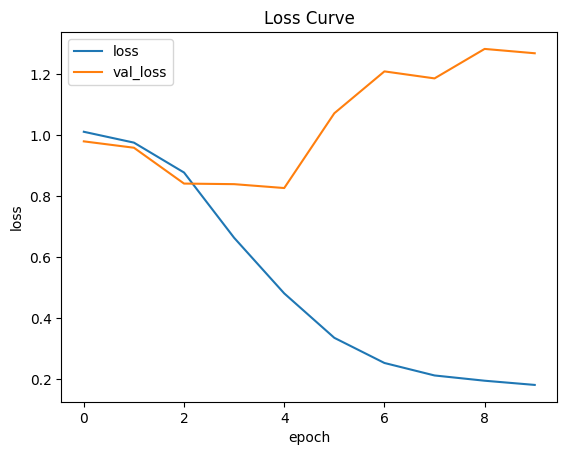

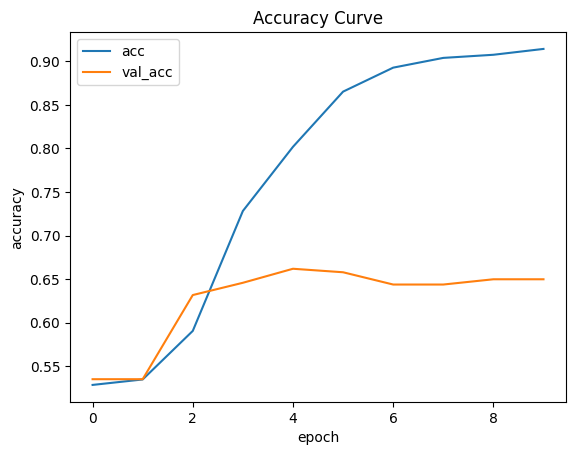

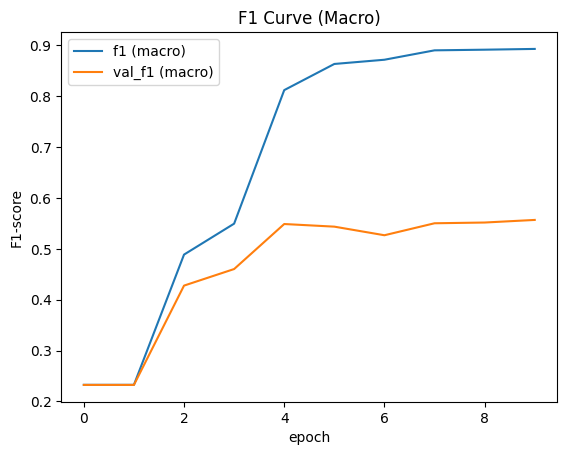

In [92]:
# Loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('Loss Curve'); plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.title('Accuracy Curve'); plt.show()

# F1 (macro) → train vs val
plt.plot(history.history['f1'], label='f1 (macro)')
plt.plot(history.history['val_f1'], label='val_f1 (macro)')
plt.xlabel('epoch'); plt.ylabel('F1-score'); plt.legend(); plt.title('F1 Curve (Macro)'); plt.show()

1. Loss Curve
    - Training loss turun konsisten dari sekitar 1.02 → 0.18.
    - Validation loss justru naik setelah epoch ke-3, dari 0.83 → 1.28 di akhir.
    - Indikasi overfitting: model belajar sangat baik di data train tapi gagal generalisasi pada data validasi.

2. Accuracy Curve
    - Training accuracy meningkat signifikan dari 0.53 → 0.91.
    - Validation accuracy hanya naik sampai 0.66 lalu stagnan, tidak mengikuti pola train.
    - Model terlalu menghafal train set, tidak seimbang di validasi.

3. F1 Macro Curve (Metrik Utama)
    - Training F1 macro naik drastis dari 0.23 → 0.89.
    - Validation F1 macro naik dari 0.23 → 0.55, lalu stagnan di sekitar 0.55.
    - Walaupun ada kenaikan, gap besar antara train dan val menegaskan adanya overfitting.

In [93]:
# prediksi di validation set
p_val   = model.predict(X_val_ids)
yhat    = p_val.argmax(1)
ytrue   = y_val_ohe.argmax(1)

# hitung accuracy manual
val_acc = (yhat == ytrue).mean()

print(f"val_acc : {val_acc:.4f}\n")
print(classification_report(
    ytrue, yhat,
    target_names=['negative','neutral','positive'],
    digits=4
))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
val_acc : 0.6620

              precision    recall  f1-score   support

    negative     0.3023    0.1781    0.2241        73
     neutral     0.7399    0.7594    0.7495       266
    positive     0.6298    0.7215    0.6726       158

    accuracy                         0.6620       497
   macro avg     0.5574    0.5530    0.5487       497
weighted avg     0.6407    0.6620    0.6479       497



Per Kelas
- Negative → F1-score 0.2241
    - Sangat rendah, artinya model gagal mengenali kelas negatif dengan baik.
- Neutral → F1-score 0.7495
    - Cukup tinggi dan stabil, menunjukkan model paling baik dalam mendeteksi kelas ini.
- Positive → F1-score 0.6726
    - Relatif bagus, meski masih di bawah Neutral.

Rata-rata
- Macro-F1 = 0.5487
    - Ini jadi metrik utama. Nilai ini menunjukkan performa model masih moderat, karena ada gap besar antar kelas (neutral tinggi, negative sangat rendah).
- Weighted-F1 = 0.6479
    - Lebih tinggi karena kelas Neutral mendominasi jumlah data, jadi menutupi kelemahan kelas lain.

Kesimpulan F1-score
- Model sudah cukup baik pada Neutral dan Positive, dengan F1 mendekati 0.7.
- Kinerja buruk di kelas Negative (0.2241) sangat menurunkan Macro-F1.
- Secara keseluruhan, Macro-F1 0.5487 menunjukkan performa masih sedang, belum bisa dikategorikan bagus, tapi lebih baik daripada baseline sebelumnya yang jauh lebih rendah.

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


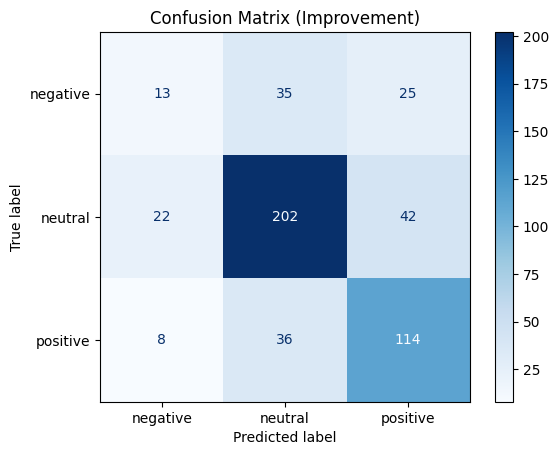

In [96]:
# Prediksi di validation set
y_pred_prob = model.predict(X_val_ids)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val_ohe, axis=1)

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['negative', 'neutral', 'positive']

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (Improvement)")
plt.show()

1. Kelas Negative
    - True Positive: 13
    - False Negative: 35 + 25 = 60
    - False Positive: 22 + 8 = 30
    - Precision rendah karena banyak contoh negative diprediksi sebagai neutral/positive.
2. Kelas Neutral
    - True Positive: 202
    - False Negative: 22 + 42 = 64
    - False Positive: 35 + 36 = 71
    - Prediksi netral paling dominan dan relatif stabil (202 benar dari 266 data).
3. Kelas Positive
    - True Positive: 114
    - False Negative: 8 + 36 = 44
    - False Positive: 25 + 42 = 67
    - Model mampu menangkap sebagian besar data positive (114/158)

## **Model Saving**

In [97]:
# Save model (Improvement-2)
EXP = "impr2"

model.save(f"model_{EXP}.keras")
print("Model saved successfully!")

Model saved successfully!


- Menentukan nama eksperimen (impr2).
- Menyimpan model hasil training ke file model_impr2.keras.
- Print pesan konfirmasi kalau model berhasil disimpan.

In [98]:
files.download(f"model_{EXP}.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Memungkinkan untuk mendownload file model (model_impr2.keras) ke lokal dari environment.

In [ ]:
_ = text_vectorization.get_vocabulary()  
print("ok. vocab size:", len(text_vectorization.get_vocabulary()))
print("max_len      :", text_vectorization.get_config()["output_sequence_length"])

ok. vocab size: 9550
max_len      : 48


- Mengecek jumlah vocabulary hasil text vectorization (9550).
- Mengecek panjang maksimal sequence yang dipakai model (48).

In [ ]:
# save vocabulary (1 token per baris)
vocab = text_vectorization.get_vocabulary()
pd.Series(vocab).to_csv(f"vocab_{EXP}.txt", index=False, header=False)

# save config penting biar bisa rebuild di VS Code
cfg = {
    "max_len":      text_vectorization.get_config()["output_sequence_length"],
    "standardize":  text_vectorization.get_config()["standardize"],  
    "split":        text_vectorization.get_config()["split"],        
    "output_mode":  text_vectorization.get_config()["output_mode"], 
}
json.dump(cfg, open(f"tv_cfg_{EXP}.json","w"))


- Menyimpan daftar kata hasil vectorization ke file .txt.
- Gunanya supaya model bisa dipakai ulang tanpa harus melakukan training ulang text vectorizer.
- Menyimpan konfigurasi penting text_vectorization (seperti panjang maksimal sequence, cara normalisasi, cara split kata, dan output mode) ke file .json.
- Tujuannya: biar bisa rebuild ulang vectorizer di luar notebook (misal di VS Code) tanpa harus definisi ulang dari awal.

In [ ]:
class_names = np.array(['negative','neutral','positive'])
np.save(f"class_names_{EXP}.npy", class_names)

try:
    pd.DataFrame(history.history).to_csv(f"train_history_{EXP}.csv", index=False)
except:
    pass

print("optional artefacts saved (labels/history jika ada).")

- Class Names disimpan ke .npy agar model tahu urutan label (negative, neutral, positive).
- Training history (loss, accuracy, f1 tiap epoch) disimpan ke .csv supaya bisa dianalisis atau diplot ulang nanti.

In [ ]:
files.download(f"vocab_{EXP}.txt")
files.download(f"tv_cfg_{EXP}.json")

Memudahkan user untuk download file vocabulary dan config ke lokal komputer.

## **Model Conclusion**

### **Apakah Improvementnya Berhasil**

**Perbandingan Classification Report**

**Baseline (Sebelum)**
- Accuracy = 0.5359
- Macro-F1 = 0.2326
- Weighted-F1 = 0.3740
- Per kelas:
    - Negative = 0.0000
    - Neutral = 0.6978
    - Positive = 0.0000

**Model Sesudah Improvement**
- Accuracy = 0.6620
- Macro-F1 = 0.5487
- Weighted-F1 = 0.6479
- Per kelas:
    - Negative = 0.2241
    - Neutral = 0.7495
    - Positive = 0.6726

**Perbandingan Confusion Matrix**
**Baseline**
- Negative: 0 benar (semua salah → bias ke neutral).
- Neutral: mayoritas benar, recall tinggi.
- Positive: 0 benar, semua salah ke neutral.

**Sesudah Improvement**
- Negative: 13 dari 73 benar (sebelumnya 0).
- Neutral: 202 dari 266 benar (cukup stabil).
- Positive: 114 dari 158 benar (sebelumnya gagal total).

**Perbandingan F1 Macro Curve**
- Baseline: naik tipis dari 0.16 → 0.30, stagnan.
- Sesudah Improvement: naik dari 0.23 → ~0.55, lalu stabil.

**Kesimpulan Perbandingan**
- Macro-F1 naik signifikan → dari 0.23 → 0.55 (+0.32).
- Accuracy juga meningkat → dari 0.53 → 0.66 (+0.13).
- Model yang dulu hanya mengenali neutral sekarang sudah bisa mengenali positive dengan baik (F1 = 0.67) dan mulai mengenali negative (walau masih rendah, F1 = 0.22).
- Gap train vs validation masih besar (overfitting), tapi generalization jauh lebih baik dibanding baseline.
- Jadi, model jelas mengalami peningkatan performa, terutama pada F1 macro yang jadi metrik utama.

### **Kelebihan dan Kekurangan**

**Kelebihan Model**
1. F1 Macro meningkat signifikan
    - Dari baseline 0.23 → 0.55, artinya model lebih seimbang dalam menangani semua kelas.
2. Kinerja bagus di kelas neutral dan positive
    - F1 Neutral = 0.7495, F1 Positive = 0.6726 → sudah cukup kuat dan konsisten.
3. Mulai bisa mengenali kelas negative
    - Sebelumnya F1 = 0.0000, sekarang naik jadi 0.2241.
4. Accuracy lebih tinggi
    - Dari 53% → 66%, mendukung adanya perbaikan performa keseluruhan.

**Kekurangan Model**
1. Kelas negative masih lemah
    - F1 hanya 0.2241, recall rendah (banyak data negative salah diprediksi sebagai neutral).
2. Overfitting
    - Training F1 mendekati 0.90, sedangkan Validation F1 hanya ~0.55 → model belum mampu generalisasi dengan baik.
3. Bias ke kelas neutral
    - Sebagian besar prediksi diarahkan ke kelas neutral, membuat imbalance performa antar kelas.

4. Macro F1 masih kategori sedang
    - Nilai 0.55 belum cukup tinggi untuk aplikasi nyata yang butuh akurasi tinggi terutama di kelas minoritas.

### **Future Improvement**

1. **Aktifkan penyeimbang kelas (class weight atau oversampling)**
- Alasan: Macro-F1 turun karena kelas negative lemah. Menambah bobot/contah untuk negative bantu naikin recall & F1 kelas minoritas → Macro-F1 naik.

2. **Transfer learning: BERT/FinBERT/IndoBERT (fine-tune)**

- Alasan: Model pretrain peka konteks (negasi, istilah finansial). Biasanya meningkatkan precision/recall di kelas sulit → dorong Macro-F1 lebih tinggi.

### **Kesimpulan**

Berdasarkan hasil eksperimen yang dilakukan, model Artificial Neural Network (ANN) yang dikembangkan mampu mengklasifikasikan teks finansial ke dalam tiga kategori sentimen (positif, netral, negatif). Dengan macro F1-score sebesar ±0.55, model sudah menunjukkan peningkatan performa dibanding baseline sebelumnya yang hanya mencapai sekitar 0.23. Hal ini menandakan bahwa model lebih seimbang dalam mengenali ketiga kelas, meskipun performa pada kelas negatif masih menjadi kelemahan utama.

Secara spesifik:
- Kelas positif dan netral memiliki F1-score relatif tinggi (sekitar 0.67–0.74), menunjukkan kemampuan model yang cukup baik dalam menangkap optimisme maupun komentar netral dalam teks finansial.
- Kelas negatif masih rendah (sekitar 0.22 F1-score), sehingga model sering gagal mengenali berita buruk atau masalah operasional sebagai negatif.

Keterkaitan dengan Objective

Hasil ini menunjukkan bahwa model dapat digunakan sebagai alat bantu awal untuk:
- Membantu investor membaca arah sentimen pasar secara lebih cepat.
- Membantu perusahaan memahami persepsi publik terhadap produk atau layanan finansialnya.
- Menyediakan dasar bagi peneliti dalam melakukan eksplorasi lebih lanjut pada data teks finansial.

Namun, untuk mendukung pengambilan keputusan yang lebih presisi khususnya dalam mendeteksi risiko atau sentimen negatif diperlukan pengembangan lanjutan pada model.